In [2]:
import os, json, random, cv2
import torch, torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from pycocotools.coco import COCO
import pycocotools.mask as mask_util

from tqdm import tqdm
import numpy as np

In [2]:
# load the annotations
with open('../Downloads/gzgc.coco/annotations/instances_train2020.json') as f:
  data_train = json.load(f)
f.close()

# initialize COCO api for instance annotations
annFile='../Downloads/gzgc.coco/annotations/instances_train2020.json'
coco_train=COCO(annFile)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [3]:
def compute_iou(box_1, box_2):
    '''
    This function takes a pair of bounding boxes and returns intersection-over-
    union (IoU) of two bounding boxes.
    '''
#     iou = np.random.random()

    # separate out coordinate so it's easier for me to think about
    box1_tl_row, box1_tl_col, box1_br_row, box1_br_col = box_1
    box2_tl_row, box2_tl_col, box2_br_row, box2_br_col = box_2
    
    # calculate the intersection coordinates
    tl_row_i = max(box1_tl_row, box2_tl_row)
    tl_col_i = max(box1_tl_col, box2_tl_col)
    br_row_i = min(box1_br_row, box2_br_row)
    br_col_i = min(box1_br_col, box2_br_col)
    
    # calulate dimensions of intersection box
    intersect_height = br_col_i - tl_col_i 
    intersect_width = br_row_i - tl_row_i
    
    # see if there is intersection between two boxes
    if (tl_row_i >= br_row_i) or (tl_col_i >= br_col_i):
        intersection_area = 0
    else:
        intersection_area = intersect_height * intersect_width
    
    # calculate area of both boxes
    box1_height = box1_br_col - box1_tl_col
    box1_width = box1_br_row - box1_tl_row
    box1_area = box1_height * box1_width
    
    box2_height = box2_br_col - box2_tl_col
    box2_width = box2_br_row - box2_tl_row
    box2_area = box2_height * box2_width
    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    
    assert (iou >= 0) and (iou <= 1.0)

    return iou

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

In [6]:
# for every annotation

for i, ann in tqdm(enumerate(data_train['annotations'])):
    ann_img_id = ann['image_id']
    ann_img_idx = ann_img_id - 1
    ann_img_file = data_train['images'][ann_img_idx]['file_name']
    ann_bbox = ann['bbox']
    ann_bbox_tlbr = [ann_bbox[0], ann_bbox[1], ann_bbox[0]+ann_bbox[2], ann_bbox[1]+ann_bbox[3]]
    image_path = f"../Downloads/gzgc.coco/images/train2020/{ann_img_file}"
    
    # get the mask rcnn bounding boxes
    im = cv2.imread(image_path)
    outputs = predictor(im)
    maskrcnn_bbox_list = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    maskrcnn_mask_list = outputs["instances"].pred_masks.numpy()

    ious = []
    for box in maskrcnn_bbox_list:
        iou = compute_iou(ann_bbox_tlbr, box)
        ious.append(iou)
    max_idx = np.argmax(ious)
    maskrcnn_bbox = maskrcnn_bbox_list[max_idx]
    maskrcnn_mask = maskrcnn_mask_list[max_idx]
    maskrcnn_mask_rle = mask_util.encode(np.asfortranarray(maskrcnn_mask))
    
    data_train['annotations'][i]['bbox_tlbr'] = ann_bbox_tlbr
    data_train['annotations'][i]['maskrcnn_bbox'] = maskrcnn_bbox
    data_train['annotations'][i]['maskrcnn_mask_rle'] = maskrcnn_mask_rle

6925it [12:25:30,  6.46s/it]


In [8]:
type(data_train['annotations'][i]['bbox_tlbr'])

list

In [21]:
data_train['annotations'][0]['bbox_tlbr']

[895.5, 437.0, 2116.5, 1127.0]

In [17]:
type(data_train['annotations'][i]['maskrcnn_bbox'])

list

In [16]:
for i in np.arange(len(data_train['annotations'])):
    data_train['annotations'][i]['maskrcnn_bbox'] = data_train['annotations'][i]['maskrcnn_bbox'].tolist()

In [20]:
data_train['annotations'][0]['maskrcnn_bbox']

[892.2218017578125, 342.18585205078125, 2136.425048828125, 1332.93896484375]

In [12]:
type(data_train['annotations'][i]['maskrcnn_mask_rle'])

dict

In [13]:
data_train['annotations'][i]['maskrcnn_mask_rle']

{'size': [2000, 3000],
 'counts': b'Xi[Y28Rn18J6K5K5K5L3M4M3L3N3M2N2N3M2N2N3N1O3L3N2N3L4M4L4K5L5K4L3L5L3M3M2M4M2N2N2N2M3N2N2N3M2N3M3M4L6J5K6J5K6J5K5K6J5K5J5L3M3M2N2N2N2N3M2N3M2N4L3M4L4L5K6J8H8H7I6J5K5K5K4L4L3M4L3M3M4L4L5L4K6J7I7I9Ge0[Of0ZO`0@8H8H6J6J5L4K4L4L4L4L4L5K5L5J6J7I8H9H<C=C>XnNc_Oad0k`0\\ZO]@Qe0k?_ZOo@od0V?eZO^Aod0e>fZOgAUe0]>aZOnAZe0V>\\ZOTB`e0o=XZOZBde0i=UZO_Bge0d=RZOcBle0^=oYOhBne0Z=mYOkBQf0W=jYOoBSf0T=gYORCVf0Q=cYOVCZf0m<_YO[C]f0h<\\YO_Caf0e<VYOeCef0`<QYOjCjf0_<hXOlCRg0]<^XOoC]g0Z<SXORDhg0W<cWO[DWh0n;TWOcDgh0k;`VOeD[i0WKYUOS:;UKWj0[JVVOj:eNYKPk0aIQWOkf0kh0jXOhWOSg0Th0eXO[XOWg0ag0fXOiXOVg0Tg0gXORYOXg0lf0eXOZYO[g0cf0bXObYO^g0\\f0`XOiYO`g0Uf0\\XOPZOdg0oe0XXOWZOhg0ge0TXO`ZOkg0]e0RXOiZOng0Ue0nWOR[OQh0ld0jWO\\[OVh0ad0eWOh[OZh0Ud0`WOV\\O_h0fc0[WOe\\Odh0Wc0UWOV]Ojh0eb0oVOh]Ooh0Tb0kVOW^OTi0ea0fVOf^OXi0Wa0bVOS_O]i0j`0_VO]_Oai0``0ZVOh_Oei0W`0VVOP@ii0n?SVOX@li0g?QVO^@oi0a?lUOd@Tj0[?iUOj@Vj0V?fUOn@Zj0S?aUORA^j0o>\\UOWAcj0k>WUO[Ahj0e>RUObAmj0Ti0N2N3O101N2O3L10O000O1N2N2N1N100O1O1O0000100

In [24]:
# necessary to convert 'counts' bytes object into something that is JSON serializable for saving
for i in np.arange(len(data_train['annotations'])):
    data_train['annotations'][i]['maskrcnn_mask_rle']['counts'] = data_train['annotations'][i]['maskrcnn_mask_rle']['counts'].decode('utf-8')

In [25]:
out_path = '../Downloads/gzgc.coco/annotations/'
with open(out_path + 'instances_train2020_maskrcnn.json', 'w') as out:
    json.dump(data_train, out, indent = 4, ensure_ascii = False)

In [27]:
test

{'size': [2000, 3000],
 'counts': b'hgbf1g0[m1f0@?H8G7J2M3N3M2N2N2N1O2N2O1N2N1O2O0O2N2O0O100O1O100O1O1O1O1O1O1O1O1O1O1O1N2N2O1N2N2O1N2O1O1N2O1O1O1O1O1O2N1O1O1O1O100O1O1O100O1O1O010O001O001O1O0O2O000O2O0O2N100O101N1O100O1O1O1O100O1O1O2O0000001O001O00010O001O010O10O0100O1O010O1O1O10O01O1O1O1O001O1N2O1O0O2N2O1N1O2O1N2O1O0O2O1O1O1O00100O1O1O010O1O100O00100O100O00100O1O1O001O1O1O001O1N2L3M4L4L4L3L5L4K5D;F;F:L3O2O1N101O1N101O1O001O1O010O001O100000100O1O00100O001O10O01O1O010O1O0010O01O1O010O001O010O001O010O0010O01O0010O01O010O001O0100O1000000O10001O1O1O1O10010O0010O010000000O1O1N2N100O00001O000O1000000O01000O10O010O0100O0100O0100O01000O100000000000001O001O100O1O1O1O1O1N101O001N101O0O101O0O100O100O1O100O100O1O00100O1O1O100O1O2O0O1O2O0O2N2O1N2N2O1N3N2M4L4M4K3N3L3N2M3N2M3N0O100O2O000O1000O0100000O010000O1000O0100O2O000O101N101N101N2O1N2O1N2O1N2O0O2O1N1O101N100O1O2O0O100O1O100O00100O100O100O10000O10000O2O00001O001O1O010O1O100O2N1O1O3M3M3M2N2N2M3N2N2N1N2O1O1N2O1O0O2O0O101O0O10001N101O1O001O1O1O1O2

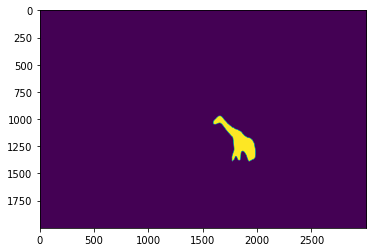

In [12]:
plt.imshow(mask_util.decode(data_train['annotations'][4]['maskrcnn_mask_rle']))

In [4]:
import json
import numpy as np
import pycocotools.mask as mask_util

In [3]:
# load the annotations
with open('../Downloads/gzgc.coco/annotations/instances_train2020_maskrcnn.json') as f:
  data_train = json.load(f)
f.close()

In [17]:
data_train['annotations'][0]

{'bbox': [895.5, 437.0, 1221.0, 690.0],
 'theta': 0.0,
 'viewpoint': 'left',
 'segmentation': [[896, 437, 2116, 437, 2116, 1127, 896, 1127, 896, 437]],
 'segmentation_bbox': [896, 437, 1220, 690],
 'area': 841800,
 'iscrowd': 0,
 'id': 1,
 'image_id': 1,
 'category_id': 1,
 'uuid': '7cfac6bc-379a-4859-a5c8-b21b06d2fe3d',
 'individual_ids': [2, 1, 3, 3459],
 'isinterest': 0,
 'name': 'IBEIS_PZ_1561',
 'review_ids': [],
 'bbox_tlbr': [895.5, 437.0, 2116.5, 1127.0],
 'maskrcnn_bbox': [892.2218017578125,
  342.18585205078125,
  2136.425048828125,
  1332.93896484375],
 'maskrcnn_mask_rle': {'size': [2000, 3000],
  'counts': 'hgbf1g0[m1f0@?H8G7J2M3N3M2N2N2N1O2N2O1N2N1O2O0O2N2O0O100O1O100O1O1O1O1O1O1O1O1O1O1O1N2N2O1N2N2O1N2O1O1N2O1O1O1O1O1O2N1O1O1O1O100O1O1O100O1O1O010O001O001O1O0O2O000O2O0O2N100O101N1O100O1O1O1O100O1O1O2O0000001O001O00010O001O010O10O0100O1O010O1O1O10O01O1O1O1O001O1N2O1O0O2N2O1N1O2O1N2O1O0O2O1O1O1O00100O1O1O010O1O100O00100O100O00100O1O1O001O1O1O001O1N2L3M4L4L4L3L5L4K5D;F;F:L3

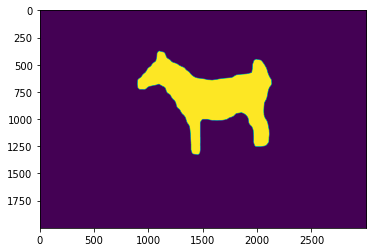

In [9]:
temp = mask_util.decode(data_train['annotations'][0]['maskrcnn_mask_rle'])
plt.imshow(temp)

In [14]:
segImage = im.copy()
binaryMask = (temp > 0.5).astype(np.float32)
segImage[np.where(binaryMask == 0.0)] = 0
image = Image.fromarray(np.uint8(segImage)).convert('RGB')

In [15]:
type(image)

PIL.Image.Image

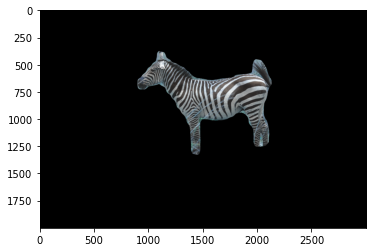

In [16]:
plt.imshow(image)

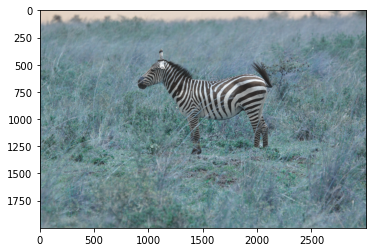

In [8]:
im = cv2.imread("../Downloads/gzgc.coco/images/train2020/000000000001.jpg");
plt.imshow(im)

In [ ]:
for ann in data_train['annotations']:
    ann_img_id = ann['image_id']
    ann_img_idx = ann_img_id - 1
    ann_img_file = data_train['images'][ann_img_idx]['file_name']
    
    